In [221]:
import numpy as np
from matplotlib import pyplot as plt
from functools import lru_cache
import functools
import sys
import gc

# importation des paramètres


In [222]:
CELLShive = 250000

# La durée de vie en jour, par catégorie
LIFESPANegg = 3
LIFESPANlarva = 5
LIFESPANpupa = 12

# La répartition des abeilles infirmières
NEEDnurses_per_pupa = 0.33
NEEDnurses_per_egg = 0.33
NEEDnurses_per_larva = lambda i: [.1,.5,.75,1.75,3][i]

# Les differents besoins en pollen
POLLENNEEDadult = .004
POLLENNEEDnurse = .05
POLLENNEEDlarva = lambda i: [.001,.003 , .006, .012, .027][i]

# Les differents besoins en nectar
NECTARNEEDlarva = lambda i: [.006,.018,.04,.09,.185][i]
NECTARNEEDadult = .005
NECTARNEEDnurse = .02
NECTARNEEDactiveforager = .02

# Le taux de cannibalism
CANNIBALISMhungerbase = lambda i: [.23,.3,.58,.06,0][i - 1]

# Les variables servant au calcul de l'ELR (L'activité de ponte quotidienne)
SUPthreshold = 0.2
ELRstochrange = 0.01
ELRbase = 1600

# Les diferents facteurs à prendre en compte
FACTORpollenstorage = 6
FACTORforagingsuccess = .8
FACTORminpollenforagers = .01
FACTORforagingmax = .33
FACTORpollensavingmax = .3
FACTORothertasks = 0.2

# le montant de pollen et nectar collecté à chaque voyage de recherche de nourriture
LOADpollenforager = .06
LOADnectarforager = .04
# le nombre de voyages effectués par butineur où il ramène du pollen ou/et du nectar, par jour
TURNSpollenforager = 10
TURNSnectarforager = 15

# le nombre d'abeilles qui se charge de la transformation du nectar pour une cellule
ProcessorsPerCell = 2
# le ratio de nectar qui sera transformé en miel
RATIOnectar_to_honey = .4

# Le taux de mortalité par catégorie
MORTALITYnursing = .005
MORTALITYprocessing = .005
MORTALITYforaging = .035
MORTALITYadultbase = 0.01
MORTALITYpupae = 0.001
MORTALITYlarvae = 0.01
MORTALITYeggs = 0.03

# le jour du "swarming day"
swd = 140

# Le nombre d'abeille adulte au départ
BEESadultbase = 15000

# les valeurs _t0 sont des valeurs experiementales
# que l'on prend en regardant les graphs ou experimentalement
INITpollen = 0
INITnectar = 0
INIThoney = 50000
STOCHASTIC_FACTOR = True

w_hivebase = 14000
w_cellsbase = .037
w_pollen = .23
w_nectar = .43
w_larva = lambda i: [.0002,.00059,.00331,.0644,.16][i-1]
w_honey = .5
w_egg = .0001
w_pupa = .16
w_adult = .1

# pour la température
RAIN = np.zeros(366)
TEMP = np.zeros(366)

# on utilise les températures de Paris en 2018 pour la variable température
tempAll = np.loadtxt('/2018ParisTemp.txt', unpack=True, skiprows=0)

print(tempAll.shape)

# on fait une moyenne de la journée
count = 8
i=0
while i<len(TEMP):
    TEMP[i] = np.average(tempAll[count:count+16])
    i+=1
    count+=25

# on passe la temperature en celcius
TEMP = (TEMP-32.)*(5/9)


(11287,)


# Nouvelle section

In [223]:
# pour reset le cache des fonctions 
# avant de lancer une nouvelle simulation
def reset_cache():
    wrappers = [
    a for a in gc.get_objects()
    if isinstance(a, functools._lru_cache_wrapper)]

    for wrapper in wrappers:
        wrapper.cache_clear()

# Modélisation du comportement d'une ruche
Nous faisons les hypothèses suivantes concernant le fonctionnement d'une ruche :
 - Le nombre d'oeufs ponduent par la reine dépend de la saison, du nombre de cellules restantes dans la ruche et de l'age de la reine
 - Si les conditions de la ruche sont optimales, la mortalité des abeilles est connue, et est régulée en fonction de la saison principalement
 - La survavilité des bébés dépend de la ruche (pollen, nurse to brood ratio)
 - Les conditions de la ruche sont très fortement impactées par la météo
 
Les fonctions suivantes ne sont que les fonctions décritent dans le papier décrivant Hopomo.

In [224]:
# x le vecteur des parametres x1, x2, ..., x5
@lru_cache(maxsize=None)
def season(t, x = [100, 40, 800, 100, 50]):
    return max(1 - 1 / (1 + x[0] * np.exp(-2 * t / x[1])), 1 / (1 + x[2] * np.exp(-2 * (t - x[3]) / x[4])))

# (page 5, eq 2)
@lru_cache(maxsize=None)
def CELLSempty(t):
    a, b, c, d = CELLSbrood(t), STORESpollen(t), STORESnectar(t), STOREShoney(t)
    return CELLShive - CELLSbrood(t) - STORESpollen(t) - STORESnectar(t) - STOREShoney(t)

# (page 5, eq 3)
@lru_cache(maxsize=None)
def SUPcomb(t):
    a = CELLSempty(t)
    if (a / (CELLShive + 1) < SUPthreshold):
        return CELLSempty(t) / (CELLShive + 1) * SUPthreshold
    else:
        return 1.

# (page 5, eq 4)
def ELRstoch(t):
    value = np.random.uniform(-ELRstochrange, ELRstochrange)
    return value

# (page 5, eq 5)
@lru_cache(maxsize=None)
def ELR(t):
    a = ELRstoch(t)
    value = ELRbase * (1 + a) * (1 - season(t)) * SUPcomb(t)
    return value


@lru_cache(maxsize=None)
def EGGS(i, t):
    if t==0:
        return 0
    if i ==1:
        value = ELR(t-1) * (1-MORTALITYeggs)
    elif (i==2 or i==3):
        value = EGGS(i-1, t-1)*(1-MORTALITYeggs)
    return value

# (page 5, eq 7)
@lru_cache(maxsize=None)
def CELLSeggs(t):
    value = 0
    for i in range(LIFESPANegg):
        value += EGGS(i+1,t)
    return value

In [225]:
# (page 6, eq 9)
@lru_cache(maxsize=None)
def SURVIVALlarvae(i, t):
    return (1 - CANNIBALISMlarvae(i, t)) * (1 - MORTALITYlarvae)

# (page 6, eq 10)
@lru_cache(maxsize=None)
def CANNIBALISMlarvae(i, t):
    if t == 0:
        return 0
    return CANNIBALISMhungerbase(i) * (1 - (INDEXpollensituation(t - 1) * INDEXnursingquality(t - 1)))

# (page 6, eq 11)
@lru_cache(maxsize=None)
def LARVAE(i, t):
    if t <= 0:
        return 0
    if i == 1:
        return EGGS(LIFESPANegg, t - 1) * SURVIVALlarvae(1, t)
    elif i<=LIFESPANlarva:
        return LARVAE(i - 1, t - 1) * SURVIVALlarvae(i, t)
    else:
        raise Exception("LARVAE age error")

# (page 6, eq 14)
@lru_cache(maxsize=None)
def PUPAE(i, t):
    if t == 0:
        return 0
    if i == 1:
        return LARVAE(LIFESPANlarva, t - 1) * (1 - MORTALITYpupae)
    elif i<=LIFESPANpupa:
        return PUPAE(i - 1, t - 1) * (1 - MORTALITYpupae)
    else:
        raise Exception("PUPAE age error")
    
# (page 6, eq 15)
@lru_cache(maxsize=None)
def CELLSpupae(t):
    value = 0
    for i in range(LIFESPANpupa):
        value += PUPAE(i+1,t)
    return value

# (page 6, eq 17)
@lru_cache(maxsize=None)
def CELLSbrood(t):
    a, b, c = CELLSeggs(t), CELLSlarvae(t), CELLSpupae(t)
    return CELLSeggs(t) + CELLSlarvae(t) + CELLSpupae(t)

# (page 6, eq 12)
@lru_cache(maxsize=None)
def CELLSlarvae(t):
    value = 0
    for i in range(LIFESPANlarva):
        value += LARVAE(i+1,t)
    return value

In [226]:
# (page 7, eq 18)
@lru_cache(maxsize=None)
def MORTALITYadult(t):
    if t == 0:
        return MORTALITYadultbase
    
    NURSErate = MORTALITYnursing*(NURSES(t-1)/(BEESadult(t-1)+1))
    PROCESSORrate = MORTALITYprocessing*(PROCESSORS(t-1)/(BEESadult(t-1)+1))
    FORAGERrate = MORTALITYforaging*(FORAGERSactive(t-1)/(BEESadult(t-1)+1))

    value = MORTALITYadultbase + NURSErate + PROCESSORrate + FORAGERrate
    return value

@lru_cache(maxsize=None)
def BEESswarm(t):
    if t == swd:
        return BEESadult(t - 1) * 0.6
    else:
        return 0

# page 7, eq 19
@lru_cache(maxsize=None)
def BEESadult(t):
    if t == 0:
        return BEESadultbase
    return (BEESadult(t - 1) + PUPAE(LIFESPANpupa, t - 1)) * (1 - MORTALITYadult(t))

In [227]:
# page 7, eq 20
@lru_cache(maxsize=None)
def INDEXrain(t):
    return 1 - RAIN[t]

@lru_cache(maxsize=None)
def HOURSraining_during_daylight(t):
    return 0

@lru_cache(maxsize=None)
def HOURSdaylight(t):
    return 12

# page 7, eq 22
@lru_cache(maxsize=None)
def INDEXtemperature(t):
    temp = TEMP[t]
    if temp > 14 and temp <= 22:
        return (temp - 14) / 8
    if temp > 22 and temp <= 32:
        return 1
    if temp > 32 and temp <= 40:
        return (40 - temp) / 8
    else:
        return 0

# page 7, eq 23
@lru_cache(maxsize=None)
def INDEXflight(t):
    return INDEXrain(t) * INDEXtemperature(t)

# page 8, eq 24
@lru_cache(maxsize=None)
def INDEXnectaroutside(t):
    return min((1 - season(t)) * 1.5, 1)

# page 8, eq 25
@lru_cache(maxsize=None)
def INDEXpollenoutside(t):
    return min((1 - season(t)) * 1.5, 1)

In [228]:

# page 8, eq 26
@lru_cache(maxsize=None)
def NEEDworkers(t):
    return NEEDnurses(t) + NEEDpollenforagers(t)

# page 8, eq 27
@lru_cache(maxsize=None)
def RATIOworkforce(t):
    return min(BEESadult(t) * (1 - FACTORothertasks) / (NEEDworkers(t) + 1), 1)

# page 8, eq 28
@lru_cache(maxsize=None)
def NEEDnurses(t):
    value = np.sum([LARVAE(i + 1, t) * NEEDnurses_per_larva(i) for i in range(LIFESPANlarva)]) + CELLSeggs(t) * NEEDnurses_per_egg + CELLSpupae(t) * NEEDnurses_per_pupa 
    return value

# page 8, eq 29
@lru_cache(maxsize=None)
def NURSES(t):
    a, b = NEEDnurses(t), RATIOworkforce(t)
    value = a * b
    return value

# page 8, eq 30
@lru_cache(maxsize=None)
def INDEXnursingquality(t):
    return NURSES(t) / (NEEDnurses(t) + 1)

In [229]:
# page 9, eq 31
@lru_cache(maxsize=None)
def FORAGERS(t):
    return FORAGERSpollen(t) + FORAGERSnectar(t)

# page 9, eq 32
@lru_cache(maxsize=None)
def FORAGERSactive(t):
    return FORAGERSpollenactive(t) + FORAGERSnectaractive(t)

# page 9, eq 33
@lru_cache(maxsize=None)
def NEEDpollen(t):
    if t < 0:
        raise Exception("NEEDpollen t<0")
    return NEEDpollen_larvae(t) + NEEDpollen_adult(t)

# page 9, eq 34
@lru_cache(maxsize=None)
def NEEDpollen_larvae(t):
    return np.sum([POLLENNEEDlarva(i) * LARVAE(i + 1, t) for i in range(LIFESPANlarva)])

# page 9, eq 35
@lru_cache(maxsize=None)
def NEEDpollen_adult(t):
    return BEESadult(t) * POLLENNEEDadult + NURSES(t) * POLLENNEEDnurse

# page 9, eq 36
@lru_cache(maxsize=None)
def NEEDpollenincome(t):
    value = 0.
    avgNeed = 0
    if t == 0:
        avgNeed = 0
    else:
        avgNeed = NEEDpollen(t)
    value = avgNeed*FACTORpollenstorage - STORESpollen(t)
    if value>0.:
        value= value
    else:
        value = 0.
    return value

# page 9, 37
@lru_cache(maxsize=None)
def NEEDpollenforagers(t):
    if t == 0:
        return NEEDpollenincome(0) / (LOADpollenforager * TURNSpollenforager * FACTORforagingsuccess)
    return NEEDpollenincome(t - 1) / (LOADpollenforager * TURNSpollenforager * FACTORforagingsuccess)


In [230]:
# page 10, eq 38
@lru_cache(maxsize=None)
def FORAGERSpollen(t):
    a = NEEDpollenforagers(t) * RATIOworkforce(t)
    b = (BEESadult(t) - NURSES(t)) * FACTORminpollenforagers
    c = BEESadult(t) * FACTORforagingmax
    return min(max(a, b), c)

# page 10, eq 39
@lru_cache(maxsize=None)
def FORAGERSpollenactive(t):
    return FORAGERSpollen(t) * INDEXflight(t) * INDEXpollenoutside(t)

# page 10, eq 40
@lru_cache(maxsize=None)
def NEEDnectar(t):
    return NEEDnectar_larvae(t) + NEEDnectar_adult(t)

# page 10, eq 41
@lru_cache(maxsize=None)
def NEEDnectar_larvae(t):
    return np.sum([NECTARNEEDlarva(i) * LARVAE(i + 1, t) for i in range(LIFESPANlarva)])

# page 10, eq 42
@lru_cache(maxsize=None)
def NEEDnectar_adult(t):
    return BEESadult(t) * NECTARNEEDadult + NURSES(t) * NECTARNEEDnurse + FORAGERSactive(t) * NECTARNEEDactiveforager

# page 10, eq 43
@lru_cache(maxsize=None)
def WORKFORCEnectar(t):
    if RATIOworkforce(t) == 1:
        return (BEESadult(t) * (1 - FACTORothertasks)) - NURSES(t) - FORAGERSpollen(t)
    else:
        return 0
    
# page 10, eq 44
@lru_cache(maxsize=None)
def FORAGERSnectar(t):
    a = (BEESadult(t) * FACTORforagingmax) - FORAGERSpollen(t)
    b = WORKFORCEnectar(t) - PROCESSORS(t)
    
    return min(a, b)

# page 10, eq 45
@lru_cache(maxsize=None)
def FORAGERSnectaractive(t):
    return FORAGERSnectar(t) * INDEXflight(t) * INDEXnectaroutside(t)

In [231]:
# page 11, eq 46
@lru_cache(maxsize=None)
def INCOMEpollen(t):
    return FORAGERSpollenactive(t) * LOADpollenforager * TURNSpollenforager * FACTORforagingstoch(t) * FACTORforagingsuccess

# page 11, eq 47
@lru_cache(maxsize=None)
def FACTORforagingstoch(t):
    if STOCHASTIC_FACTOR:
        return np.random.uniform(0.75, 1.25)
    else:
        return 1

# page 11, eq 48
@lru_cache(maxsize=None)
def INDEXpollensituation(t):
    return min(1, STORESpollen(t) / (NEEDpollen(t) * FACTORpollenstorage + 1))

# page 11, eq 49
@lru_cache(maxsize=None)
def INCOMEnectar(t):
    a = FORAGERSnectaractive(t) * LOADnectarforager * TURNSnectarforager * FACTORforagingstoch(t) * FACTORforagingsuccess
    b = CELLSempty(t - 1)
    return min(a, b)

# page 11, eq 50
@lru_cache(maxsize=None)
def NEEDprocessors(t):
    return STORESnectar(t - 1) * ProcessorsPerCell

# page 11, eq 51
@lru_cache(maxsize=None)
def PROCESSORS(t):
    return min(NEEDprocessors(t), WORKFORCEnectar(t))

# page 11, eq 52
@lru_cache(maxsize=None)
def PROCESSEDnectar(t):
    if t==0:
        a = STORESnectar(0)-USAGEnectar(t)
    else:
        a = STORESnectar(t-1)-USAGEnectar(t)
    b = PROCESSORS(t)/ProcessorsPerCell
    return min(a,b)

In [232]:
# page 12, eq 53
@lru_cache(maxsize=None)
def USAGEpollen(t):
    if t == 0:
        a = STORESpollen(t)
        b = NEEDpollen(0) * (1 - (FACTORpollensavingmax * (1 - INDEXpollensituation(0))))
        return min(a, b)
    a = STORESpollen(t - 1)
    b = NEEDpollen(t - 1) * (1 - (FACTORpollensavingmax * (1 - INDEXpollensituation(t - 1))))
    return min(a, b)

# page 12, eq 54
@lru_cache(maxsize=None)
def STORESpollen(t):
    if t == 0:
        return INITpollen
    return STORESpollen(t - 1) + INCOMEpollen(t) - USAGEpollen(t)

# page 12, eq 55
@lru_cache(maxsize=None)
def USAGEnectar(t):
    if t == 0:
        return min(STORESnectar(0), NEEDnectar(t))
    return min(STORESnectar(t - 1), NEEDnectar(t))

# page 12, eq 56
@lru_cache(maxsize=None)
def USAGEhoney(t):
    if t == 0:
        return min(STOREShoney(0), (NEEDnectar(t) - USAGEnectar(t)) * RATIOnectar_to_honey)
    return min(STOREShoney(t - 1), (NEEDnectar(t) - USAGEnectar(t)) * RATIOnectar_to_honey)

# page 12, eq 57
@lru_cache(maxsize=None)
def STORESnectar(t):
    if t <= 0:
        return INITnectar
    return STORESnectar(t - 1) + INCOMEnectar(t) - USAGEnectar(t) - PROCESSEDnectar(t)

# page 12, eq 58
@lru_cache(maxsize=None)
def STOREShoney(t):
    if t == 0:
        return INIThoney
    return STOREShoney(t - 1) - USAGEhoney(t) + (PROCESSEDnectar(t) * RATIOnectar_to_honey)

# page 12, eq 59
@lru_cache(maxsize=None)
def WEIGHTcolony(t):
    tmp = np.sum([w_larva(i) * LARVAE(i + 1, t) for i in range(LIFESPANlarva)])
    return 1/1000 * (w_hivebase + w_cellsbase * CELLShive + w_pollen * STORESpollen(t) + w_nectar * STORESnectar(t) + w_honey * STOREShoney(t) + w_egg * CELLSeggs(t) + w_pupa * CELLSpupae(t) + tmp + w_adult * BEESadult(t))

# page 13, eq 60
@lru_cache(maxsize=None)
def BEESlazy(t):
    return (BEESadult(t) * (1 - FACTORothertasks)) - FORAGERSactive(t) - NURSES(t) - PROCESSORS(t)

# Simulations
Nous allons faire tourner nos équations sur les paramètres décrits dans le papier.
Aussi nous avons du estimer nous même une partie des paramètres car ils n'étaient pas écrit dans la papier.

### Simulation du nombre d'oeufs

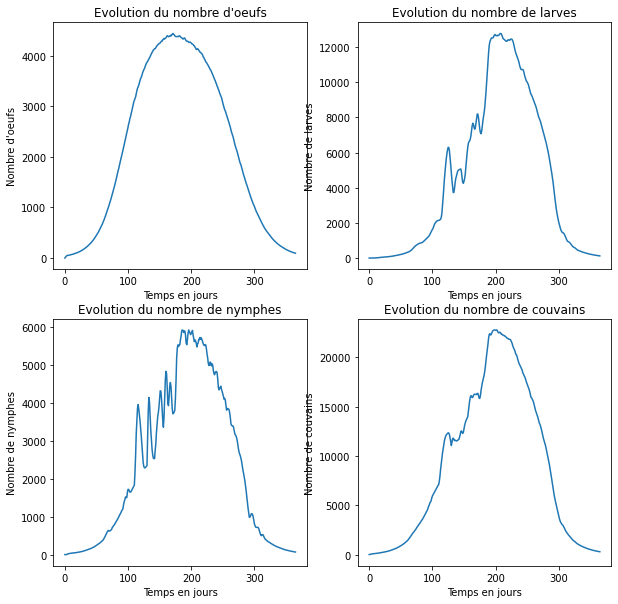

In [233]:
reset_cache()

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))


a, b, c, d = [], [], [], []

time = np.arange(366)

for t in time:
    a.append(CELLSeggs(t))
    b.append(CELLSlarvae(t))
    c.append(CELLSpupae(t))
    d.append(CELLSbrood(t))

ax[0,0].plot(a)
ax[0,0].set_title("Evolution du nombre d'oeufs")
ax[0,0].set_xlabel("Temps en jours")
ax[0,0].set_ylabel("Nombre d'oeufs")
ax[1,0].plot(b)
ax[1,0].set_title("Evolution du nombre de nymphes")
ax[1,0].set_xlabel("Temps en jours")
ax[1,0].set_ylabel("Nombre de nymphes")
ax[0,1].plot(c)
ax[0,1].set_title("Evolution du nombre de larves")
ax[0,1].set_xlabel("Temps en jours")
ax[0,1].set_ylabel("Nombre de larves")
ax[1,1].plot(d)
ax[1,1].set_title("Evolution du nombre de couvains")
ax[1,1].set_xlabel("Temps en jours")
ax[1,1].set_ylabel("Nombre de couvains")
plt.show()

In [234]:
from tqdm import tqdm

# Fonction permettant de simuler le comportement de la vie d'une ruche
def run_multiple_simul(N=1):
    simul_data = {
        "bees_adult": [],
        "pollen_store": [],
        "brood_cells": [],
        "honey_store": [],
        "colony_weight": [],
        "ELR": [],
    }
    for _ in tqdm(range(N)):
        reset_cache()
        time = np.arange(366)
        a, b, c, d, e, f = [], [], [], [], [], []
        
        for t in time:
            a.append(BEESadult(t))
            b.append(STORESpollen(t))
            c.append(CELLSbrood(t))
            d.append(STOREShoney(t))
            e.append(WEIGHTcolony(t))
            f.append(ELR(t))
            
        simul_data["bees_adult"].append(a.copy())
        simul_data["pollen_store"].append(b.copy())
        simul_data["brood_cells"].append(c.copy())
        simul_data["honey_store"].append(d.copy())
        simul_data["colony_weight"].append(e.copy())
        simul_data["ELR"].append(f.copy())
        
    simul_data["bees_adult"] = np.array(simul_data["bees_adult"])
    simul_data["pollen_store"] = np.array(simul_data["pollen_store"])
    simul_data["brood_cells"] = np.array(simul_data["brood_cells"])
    simul_data["honey_store"] = np.array(simul_data["honey_store"])
    simul_data["colony_weight"] = np.array(simul_data["colony_weight"])
    simul_data["ELR"] = np.array(simul_data["ELR"])
    
    return simul_data

# Fonction qui affiche les résultats de la simulation, sous forme de graphique.
def plot_simul_data(data):
    fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(15, 15))    
    ax[0,0].plot(np.percentile(test["bees_adult"], 0.5, axis=0))
    ax[0,0].set_title("Evolution du nombre d'abeilles adultes")
    ax[0,0].set_xlabel("Temps en jours")
    ax[0,0].set_ylabel("Nombre de cellules")
    ax[0,1].plot(test["pollen_store"].mean(axis=0))
    ax[0,1].set_title("Evolution du nombre de cellules remplies de pollen")
    ax[0,1].set_xlabel("Temps en jours")
    ax[0,1].set_ylabel("Nombre de cellules")
    ax[1,0].plot(test["brood_cells"].mean(axis=0))
    ax[1,0].set_title("Evolution du nombre de cellules remplies de couvain")
    ax[1,0].set_xlabel("Temps en jours")
    ax[1,0].set_ylabel("Nombre de cellules")
    ax[1,1].plot(test["honey_store"].mean(axis=0))
    ax[1,1].set_title("Evolution du nombre de cellules remplies de miel")
    ax[1,1].set_xlabel("Temps en jours")
    ax[1,1].set_ylabel("Nombre de cellules")
    ax[2,0].plot(test["colony_weight"].mean(axis=0))
    ax[2,0].set_title("Evolution du poids de la colonie")
    ax[2,0].set_xlabel("Temps en jours")
    ax[2,0].set_ylabel("Poids de la colonie (en kg)")
    ax[2,1].plot(test["ELR"].mean(axis=0))
    ax[2,1].set_title("Evolution du nombre d'oeufs pondus")
    ax[2,1].set_xlabel("Temps en jours")
    ax[2,1].set_ylabel("Nombre d'oeufs par jour")

## Simulation général du comportement d'une ruche
Simulation générale du comportement d'une ruche avec les paramètres donnés dans le papier. Nous avons essayé de trouver les paramètres que nous ne connaissions pas en nous basant sur le papier HoPoMo.

100%|██████████| 1/1 [00:00<00:00,  9.00it/s]


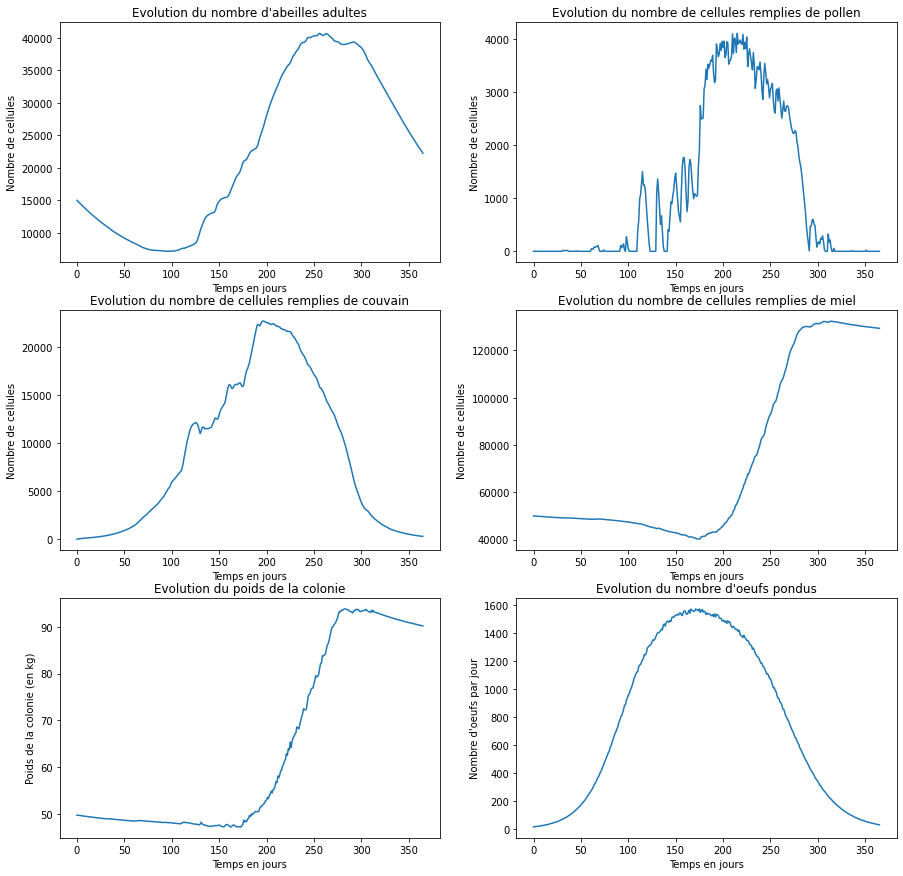

In [235]:
# Si nous faisons varier les parametres (autour d'une loi normale par exemple)
# cette fonction nous permettrait de faire tourner plusieurs simulation et
# et d'en faire la moyenne (en changeant le N=)
test = run_multiple_simul()
plot_simul_data(test)

# Analyse des résultats
Nous avons choisi 6 graphiques représentant un maximum d'informations pertinentes sur la vie de la ruche modélisé.
Ces 6 graphiques nous ont permis de comparer nos résultats à ceux de l'article afin d'évaluer notre travail et ainsi d'ajuster les paramètres.
En général nous remarquons que l'activité de la ruche est au ralenti en hiver, quand la ruche hiberne.

## Bees Adult
Ce graphique ressemble beaucoup à celui de l'article. On constate une nette croissance du nombre d'abeille en plein printemps, et ce, jusqu'au début de l'automne. Nous arrivons, au maximum à un total de 40 000 abeilles vers la fin de l'été, pour un nombre de 15 000 abeilles au début de l'année. Nous remarquons que beaucoup d'abeilles meurent durant l'hiver.

## Brood Cells
Les cellules de couvains sont plus nombreuses légèrement avant que la croissance du nombre d'abeille est forte. C'est donc normal étant donnée que ces cellules abritent les oeufs, qui seront ensuite des larves, puis des nymphes, pour finir abeille au bout de 21 jours dans cette cellule.
La courbe ressemble à peu près à celle de l'article, et on y retrouve à peu près les mêmes valeurs aux mêmes moments.
## ELR
Notre résultat sur l'activité de ponte correspond bien au graphique de l'article. Nous avons obtenu un graphique qui est également cohérant avec notre graphique des cellules de couvains.
## Pollen Store
Les variations obtenues sur le stockage de pollen sont cohérentes avec l'article. On peut bien constater que le pollen est plus ramassé et stocké lorsque les abeilles sont plus nombreuses, et durant l'été, lorsque le pollen est le plus présent dans la nature. En hiver on ne garde pas de pollen vu qu'il n'y a pas de fleurs.
## Honey Store
Le stock de miel est en adéquation avec les résultats de l'article. Nos abeilles commence l'année avec 50 000 cellules remplies (ce que laisse l'apiculteur aux abeilles pour vivre) et finisse l'année avec environ 150 000 cellules remplies, soit le triple. L'apiculteur peut donc ramasser 100 000 cellules remplies de miel à la fin de l'année.
La hausse de la production se fait bien au moment où on a le plus d'abeille, et où les butineuses vont ramener le nectar qui sera transformé par les abeilles chargées de ce travail.
## Colony Weight
Le poids de la colonie correspond bien aux graphiques de l'article, ce qui est normal étant donné que le plus lourd dans la colonie est le miel. La courbe a donc presque la même allure que celle du miel.
Il est normal que en hiver la ruche garde le plus de miel possible pour survivre (car il n'y a plus de fleurs)